In [1]:
import importlib as ipl

import os
from pathlib import Path
import uuid
import shutil
import sys
import traceback

import numpy as np
import pandas as pd

import spotpy

import pyswat
ipl.reload(pyswat)

from pyswat import SimManage, ReadOut, FileEdit

In [52]:
class swat_callib_setup(object):

    def __init__(self, swat_model, observed_data, param_defs, parallel="seq", temp_dir=None):

        self.model = swat_model
        self.observed_data = observed_data
        
        self.params = []
        for i in range(len(param_defs)):
            self.params.append(
                spotpy.parameter.Uniform(
                    name=par_file_load[i][0],
                    low=par_file_load[i][1],
                    high=par_file_load[i][2],
                    optguess=np.mean( [par_file_load[i][1], par_file_load[i][2]] )))
    
        self.temp_dir = temp_dir
        self.parallel = parallel

        if self.parallel == "seq":
            pass

        if self.parallel == "mpi":

            from mpi4py import MPI

            comm = MPI.COMM_WORLD
            self.mpi_size = comm.Get_size()
            self.mpi_rank = comm.Get_rank()
    

    def onerror(self, func, path, exc_info):
        import stat
        if not os.access(path, os.W_OK):
            # Is the error an access error ?
            os.chmod(path, stat.S_IWUSR)
            func(path)
        else:
            raise


    def prep_temp_model_dir(self):
        temp_id = uuid.uuid1()

        if self.parallel == "mpi":
            try:
                temp_id = f'mpi{self.mpi_rank}_' + str(temp_id)
            except NameError:
                pass

        test_path = f"swat_{temp_id}"

        if self.temp_dir is None:
            test_path = Path(os.path.join(os.getcwd(), test_path))
        else:
            test_path = Path(os.path.join(self.temp_dir, test_path))

        if os.path.exists(test_path):
            print('Deleting temp folder ' + str(test_path))
            shutil.rmtree(test_path, onerror=self.onerror)

        print('Copying model to folder ' + str(test_path))
        shutil.copytree(self.model.working_dir, test_path)

        try:
            return SimManage.SwatModel.loadModelFromDirectory(test_path)
        except ValueError:
            return SimManage.SwatModel.initFromTxtInOut(test_path, copy=False, force=True)
    

    def remove_temp_model_dir(self, model):
        try:
            print('Deleting temp folder ' + str(model.working_dir))
            shutil.rmtree(model.working_dir, onerror=self.onerror)
        except Exception as e:
            print(e)
            traceback.print_exc(file=sys.stdout)
            print('Error deleting tmp model run')
            pass
    

    def manipulate_model_params(self, model, parameters):

        print(f"this iteration's parameters:")
        print(parameters)
        print(self.params[0].name)
        print(parameters['v__SFTMP.bsn'])
        
        how_apply = {
            'v':'s',
            'r':'*',
            'a':'+'
        }
        
        for idx, param_string in enumerate(self.params):
            print(param_string.name)
            print(idx)
            print(len(param_string.name))
            print(parameters[idx])
            
            # slice the stringname open
            # how  param  manipu   1        2         3          4         5   (times __)
            # x__<parname>.<ext>__<hydrp>__<soltext>__<landuse>__<subbsn>__<slope>
            # [0] split ('.')  split ('__') [0]  how v_s r_* a_+  [1] param field name
            # ---
            # [1] split('__') [0] manipulator/file type [1] hydgrp ... etc
            
            left, right = param_string.name.split('.')
            how, param_field = left.split('__')
            
            right_list = right.split('__')
            manip_ext = right_list[0]
            if len(right_list) > 1:
                hydrp = right_list[1]
            if len(right_list) > 2:
                soltext = right_list[2]
            if len(right_list) > 3:
                landuse = right_list[3]
            if len(right_list) > 4:
                subbsn = right_list[4]
            if len(right_list) > 5:
                slope = right_list[5]
            
            changeHow = how_apply[how]
            
            
            print(f"field {param_field} in file/manip {manip_ext} will be changed via '{changeHow}' and value {parameters[idx]} ")
            
            manipulator_handle = model.getFileManipulators()[manip_ext]
            
            # here we could add addtional conditions for finer granularity
            for m in manipulator_handle:
                m.setChangePar(param_field, parameters[idx], changeHow)
                m.finishChangePar()
                

    def parameters(self):
        return spotpy.parameter.generate(self.params)
    
    
    # provide the available observed data
    def evaluation(self):
        # observations = [self.observed_data]
        return self.observed_data


    # Simulation function must not return values besides for which evaluation values/observed data are available
    def simulation(self, parameters):
        the_model = self.prep_temp_model_dir()
        the_model.enrichModelMeta(verbose=False)
        print(f"is it runnable: {the_model.is_runnable()}")

        self.manipulate_model_params(the_model, parameters)

        # TODO: edit the correct parameters in SWAT files

        ret_val = the_model.run(capture_logs=False, silent=False)
        print(f"returns {ret_val} - vs {the_model.last_run_succesful}")
        # print(model4.last_run_logs)

        reach = 1
        # simulated data
        reader1 = ReadOut.rchOutputManipulator(["FLOW_OUT"], [reach], "skip", True, 0, the_model.working_dir, iprint='month', stats_dir=self.temp_dir)
        sim_flow_1 = reader1.outValues["FLOW_OUT"][reach]

        # cleanup
        self.remove_temp_model_dir(the_model)
        return sim_flow_1


    # if we want to minimize our function, we can select a negative objective function
    def objectivefunction(self, simulation, evaluation):
        print("simulation")
        print(len(simulation))
        print("evaluation")
        print(len(evaluation))

        objectivefunction = spotpy.objectivefunctions.nashsutcliffe(evaluation,simulation)      
        return objectivefunction

In [53]:
model4 = {}

try:
    model4 = SimManage.SwatModel.initFromTxtInOut(txtInOut=os.path.join(os.getcwd(),
        os.path.join('data', 'TxtInOut')), copy=True, target_dir="demo_callib2", force=False)
except ValueError:
    model4 = SimManage.SwatModel.loadModelFromDirectory('demo_callib2')

model4.enrichModelMeta()
print(f"is it runnable: {model4.is_runnable()}")

# ret_val = model4.run(capture_logs=True, silent=True)
# print(f"returns {ret_val} - vs {model4.last_run_succesful}")
# print(model4.last_run_logs)

temp_dir = 'swat_b7c411b6-d727-11ea-b9a4-54e1ad562245'

subbasins = [1]

# simulated data
reader1 = ReadOut.rchOutputManipulator(["FLOW_OUT"], subbasins,"skip",False,0, model4.working_dir, iprint='month', stats_dir=temp_dir)
sim_flow_1 = reader1.outValues["FLOW_OUT"][subbasins[0]]

# observed data
obs_filename = os.path.join('data', os.path.join('observed','pori_flow_monthly_2003-2010.txt'))
efficiency = ReadOut.efficiency(output="FLOW_OUT", area=subbasins[0], observed=obs_filename, fileColumn=3, daysSkip=0, working_dir=model4.working_dir, iprint='month', nodata=-9999)

print(f"initial NSE: {efficiency.nash()}")
# print(spotpy.objectivefunctions.nashsutcliffe(efficiency.obs_masked, sim_flow_1))

# print(efficiency.obs)
# print(efficiency.obs_masked)


demo_callib2 exists ... 
not empty and no force overwrite, aborting!
demo_callib2 exists ... 
{'swat_version': '2012', 'working_dir': 'C:\\dev\\build\\test_projects\\pycharm_demo\\demo_callib2', 'metadata_obj': '.swatmodel.json', 'swat_exec': 'swat_64rel.exe', 'n_sub_basins': 53, 'n_hru': 441, 'n_years_simulated': 14, 'beginning_year_simulation': 2000, 'outprint_code': 0, 'n_years_skip': 3, 'n_days_skip': 1096, 'readout_years': 11, 'readout_days': 4382}
subs/rch 53, number of HRU 441
start year 2000, full sim length years 14
skip sim init years 3 - skip sim years in days 1096
number of years sim/obs  11 - in days 4382
sim is 0# (0 month, 1 day, 2 year)
C:\dev\build\test_projects\pycharm_demo\demo_callib2\swat_64rel.exe is executable
is it runnable: 1
initial NSE: -0.34425160308217806


In [54]:
# import functools

# if functools.reduce(lambda i, j : i and j, map(lambda m, k: m == k, efficiency.outValues, efficiency.obs_masked), True) :  
#     print ("The lists are identical") 
# else : 
#     print ("The lists are not identical") 

# run spotpy callib sampling and sensitivity

# delimiter=' ' n-consecutive whitespace is default
# dtype U utf8 string

par_file_name = os.path.join('data', os.path.join('params','par_inf.txt'))
print(f'loading parameter file {par_file_name}')

dtype=[('f0', '|U30'), ('f1', '<f8'), ('f2', '<f8')]
par_file_load = np.genfromtxt(par_file_name, dtype=dtype, encoding='utf-8')

parallel = "seq"
spot_setup=swat_callib_setup(model4, efficiency.obs_masked, par_file_load, parallel=parallel, temp_dir=temp_dir)


loading parameter file data\params\par_inf.txt


In [55]:
repetitions=5

dbformat = "csv"

lhs_calibrator_sampler = spotpy.algorithms.lhs(spot_setup, parallel=parallel, dbname='Demo4SwatLHS', dbformat=dbformat)

lhs_calibrator_sampler.sample(repetitions)



Initializing the  Latin Hypercube Sampling (LHS)  with  5  repetitions
Starting the LHS algotrithm with 5 repetitions...
Creating LatinHyperCube Matrix
Copying model to folder swat_b7c411b6-d727-11ea-b9a4-54e1ad562245\swat_e70c46d8-d7e6-11ea-8d46-54e1ad562245
swat_b7c411b6-d727-11ea-b9a4-54e1ad562245\swat_e70c46d8-d7e6-11ea-8d46-54e1ad562245 exists ... 
{'swat_version': '2012', 'working_dir': 'C:\\dev\\build\\test_projects\\pycharm_demo\\swat_b7c411b6-d727-11ea-b9a4-54e1ad562245\\swat_e70c46d8-d7e6-11ea-8d46-54e1ad562245', 'metadata_obj': '.swatmodel.json', 'swat_exec': 'swat_64rel.exe', 'n_sub_basins': 53, 'n_hru': 441, 'n_years_simulated': 14, 'beginning_year_simulation': 2000, 'outprint_code': 0, 'n_years_skip': 3, 'n_days_skip': 1096, 'readout_years': 11, 'readout_days': 4382}
C:\dev\build\test_projects\pycharm_demo\swat_b7c411b6-d727-11ea-b9a4-54e1ad562245\swat_e70c46d8-d7e6-11ea-8d46-54e1ad562245\swat_64rel.exe is executable
is it runnable: 1
this iteration's parameters:
paramete

In [56]:
callib_results = lhs_calibrator_sampler.getdata()

print(spotpy.analyser.get_best_parameterset(callib_results))


Best parameter set:
v__SFTMPbsn=-1.225, v__SMTMPbsn=1.018, v__SMFMXbsn=3.518, v__SMFMNbsn=0.65, v__TIMPbsn=0.0993
[(-1.225, 1.018, 3.518, 0.65, 0.0993)]


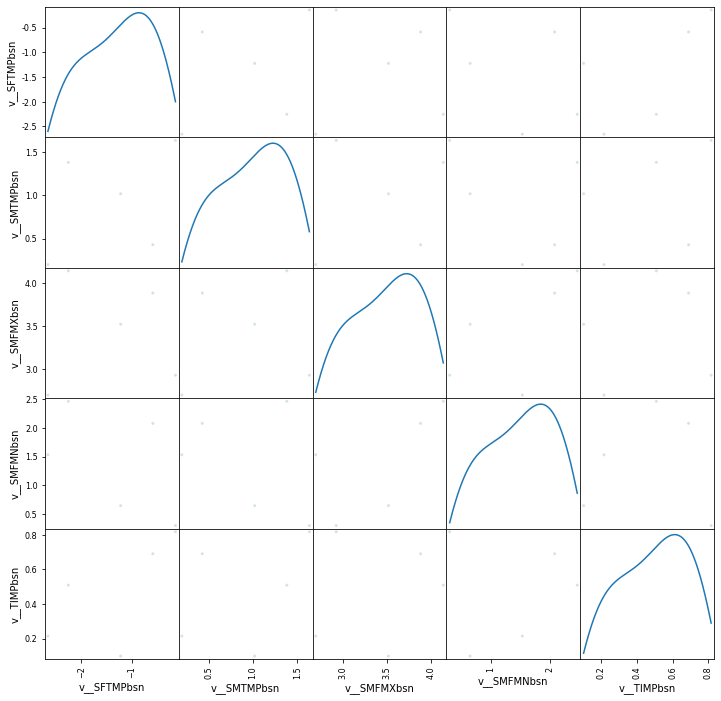

In [57]:
spotpy.analyser.plot_parameterInteraction(callib_results) 

In [63]:
callib_results
# spotpy.analyser.plot_parametertrace_algorithms(result_lists=callib_results, algorithmnames=['lhs'], spot_setup=spot_setup)


array([(-0.2063, -1.225 , 1.018 , 3.518, 0.65  , 0.0993, 0.0356 , 0.032  , 0.0648, 5.746, 6.01 , 3.174, 1.798, 0.891 , 1.781, 0.551 , 1.265, 2.049, 1.053, 0.416 , 1.671, 4.164, 1.151, 0.961 , 2.37 , 0.68  , 0.546 , 1.703, 2.836, 1.656, 4.094, 1.528, 1.674, 4.312, 1.599, 0.4905, 0.1677, 0.108 , 0.069  , 0.0733 , 0.0471 , 1.178, 0.0441 , 0.02151, 0.1254, 2.771, 0.802 , 0.03592, 0.01398, 0.02332, 0.05606, 0.0851 , 0.2427, 0.3538, 1.028, 0.7134, 3.742, 1.358, 0.2269, 0.117 , 0.0733, 0.05783, 0.08905, 0.0925, 0.0992 , 0.6377, 0.305 , 1.68 , 4.16 , 3.896, 0.4138, 0.1978, 1.378, 2.924, 0.8364, 3.494, 4.46 , 1.983, 2.031, 1.298, 3.61 , 5.45 , 0.5483, 0.2186, 0.1443, 0.118 , 0.2076, 1.221, 0.8716, 1.519, 0.1826, 0.1337, 4.71 , 8.055, 0.1832, 0.1064 , 0.134 , 0.2654, 0.139 , 0.146 , 0.6465, 1.363, 1.536, 0.6494, 1.664, 2.223 , 0.1816, 0.1327, 0.0961 , 0.1024 , 0.08344, 0.06366, 0.06464, 1.379, 0.04703, 0.02487, 1.438, 0.547 , 0.1693, 0.0925 , 0.1201, 0.08844, 0.1252, 0.7046, 0.3125, 0.313 , 0.08

In [ ]:
# fast_sensitivity_sampler = spotpy.algorithms.fast(spot_setup,  dbname='Demo4SwatFAST',  dbformat=dbformat)
# fast_sensitivity_sampler.sample(repetitions)

# sens_results = fast_sensitivity_sampler.getdata()
# spotpy.analyser.plot_parametertrace_algorithms(sens_results, ['fast'], spot_setup)

In [1]:
import numpy as np
import subprocess as sub

import importlib as ipl

import models

import os
import numpy as np
import pandas as pd

import spotpy

In [2]:
model = models.SwatModel.initFromTxtInOut(txtInOut=os.path.join(os.getcwd(),
        os.path.join('data', 'TxtInOut_pori3')), copy=True, target_dir="demo_callib2", force=False)

demo_callib2 exists ... 
not empty and no force overwrite, aborting!


ValueError: not empty and no force overwrite, aborting!

In [2]:
model = models.SwatModel.loadModelFromDirectory("demo_callib2")

demo_callib2 exists ... 
{'swat_version': '2012', 'working_dir': 'C:\\dev\\build\\test_projects\\pycharm_demo\\demo_callib2', 'metadata_obj': '.swatmodel.json', 'swat_exec': 'swat_64rel.exe'}


In [3]:
print(f"is it runnable: {model.is_runnable()}")

ret_val = model.run(capture_logs=True, silent=False)
print(f"returns {ret_val} - vs {model.last_run_succesful}")
print(model.last_run_logs)

C:\dev\build\test_projects\pycharm_demo\demo_callib2\swat_64rel.exe is executable
is it runnable: 1
SWAT2012
Rev. 635
Soil & Water Assessment Tool
PC Version
Program reading from file.cio . . . executing

Executing year    1
Executing year    2
Executing year    3
Executing year    4
Executing year    5
Executing year    6
Executing year    7
Executing year    8
Executing year    9
Executing year   10
Executing year   11
Executing year   12
Executing year   13
Executing year   14

Execution successfully completed
returns 0 - vs True
SWAT2012
Rev. 635
Soil & Water Assessment Tool
PC Version
Program reading from file.cio . . . executing

Executing year    1
Executing year    2
Executing year    3
Executing year    4
Executing year    5
Executing year    6
Executing year    7
Executing year    8
Executing year    9
Executing year   10
Executing year   11
Executing year   12
Executing year   13
Executing year   14

Execution successfully completed


In [5]:
import uuid
from pathlib import Path
import os

temp_id = uuid.uuid1()
temp_dir = Path(os.path.join(os.getcwd(), f"swat_{temp_id}"))
os.mkdir(temp_dir)

print(temp_dir)

C:\dev\build\test_projects\pycharm_demo\swat_b7c411b6-d727-11ea-b9a4-54e1ad562245


In [4]:
temp_dir = r"C:\dev\build\test_projects\pycharm_demo\swat_b7c411b6-d727-11ea-b9a4-54e1ad562245"
print(temp_dir)

model.enrichModelMeta()

C:\dev\build\test_projects\pycharm_demo\swat_b7c411b6-d727-11ea-b9a4-54e1ad562245
subs/rch 53, number of HRU 441
start year 2000, full sim length years 14
skip sim init years 3 - skip sim years in days 1096
number of years sim/obs  11 - in days 4382
sim is 0# (0 month, 1 day, 2 year)


In [5]:
subbasins = [1]

n_months = model.readout_years * 12
print(f"expected obs {n_months}")

model.stats_dir = temp_dir
reader1 = models.rchOutputManipulator(["FLOW_OUT"], subbasins,"indi",False,0, model.working_dir, iprint="month", stats_dir=temp_dir)

arr = reader1.outValues['FLOW_OUT'][subbasins[0]]

print(len(arr))

expected obs 132
132


In [7]:
print("reader1 efficiency")
# TODO: add logic for observed data?
fileName = os.path.join('data', os.path.join('observed','pori_flow_monthly_2003-2010.txt'))
efficiency = models.ReadOut.efficiency(output="FLOW_OUT", area=subbasins[0], observed=fileName, fileColumn=3, daysSkip=0, working_dir=model.working_dir, iprint="month")

print(f"efficiency.obs.min() {efficiency.obs.min()}")

# TODO: add nodata handling/masking to ReadOut and stats module
import numpy.ma as ma

obs_ma = ma.masked_where(efficiency.obs == -9999.0, efficiency.obs)
print(f" obs ma masked mean {np.mean(obs_ma)}")

print(f" obs_ma.min() {obs_ma.min()}")

print(f" len(efficiency.obs) {len(efficiency.obs)}")
print(f" len(obs_ma) {len(obs_ma)}")

print(f" efficiency.nash() {efficiency.nash()}")

reader1 efficiency
efficiency.obs.min() 0.263871
 obs ma masked mean 1.7889424166666668
 obs_ma.min() 0.263871
 len(efficiency.obs) 132
 len(obs_ma) 132
 efficiency.nash() -0.34425160308217806


In [8]:
import spotpy

spotpy.objectivefunctions.nashsutcliffe(obs_ma, arr)

-0.34425160308217806

In [22]:
dtype=[('f0', '<U12'), ('f1', '<f8'), ('f2', '<f8')]

par_file_name = os.path.join('data', os.path.join('params','par_inf.txt'))
par_file_load = np.genfromtxt(par_file_name, dtype=dtype, encoding='utf-8')  # delimiter=' ',  n-whitespace

In [25]:
par_file_load[0][1]

-3.0

In [2]:
model4 = {}

try:
    model4 = SimManage.SwatModel.initFromTxtInOut(txtInOut=os.path.join(os.getcwd(),
        os.path.join('data', 'TxtInOut')), copy=True, target_dir="demo_callib2", force=False)
except ValueError:
    model4 = SimManage.SwatModel.loadModelFromDirectory('demo_callib2')

model4.enrichModelMeta()
print(f"is it runnable: {model4.is_runnable()}")

demo_callib2 exists ... 
not empty and no force overwrite, aborting!
demo_callib2 exists ... 
{'swat_version': '2012', 'working_dir': 'C:\\dev\\build\\pyswat_scripting\\demo_callib2', 'metadata_obj': '.swatmodel.json', 'swat_exec': 'C:\\dev\\build\\test_projects\\pycharm_demo\\demo_callib2\\swat_64rel.exe', 'model_text_encoding': 'latin-1', 'n_sub_basins': 53, 'n_hru': 441, 'n_years_simulated': 14, 'beginning_year_simulation': 2000, 'outprint_code': 0, 'n_years_skip': 3, 'n_days_skip': 1096, 'readout_years': 11, 'readout_days': 4382}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
model text encoding unlikely, assuming latin-1
C:\dev\build\test_projects\pycharm_demo\demo_callib2\swat_64rel.exe not in default paths
subs/rch 53, number of HRU 441
start year 2000, full sim length years 14
skip sim init years 3 - skip sim years in days 1096
number of years sim/obs  11 - in days 4382
sim is 0# (0 month, 1 day, 2 year)
C:\dev\build\test_projects\pycharm_demo\demo_callib2\swat_64rel.

In [5]:
model4.swat_exec = 'C:\\dev\\build\\pyswat_scripting\\demo_callib2\\swat_64rel.exe'
print(f"is it runnable: {model4.is_runnable()}")

C:\dev\build\pyswat_scripting\demo_callib2\swat_64rel.exe is executable
C:\dev\build\pyswat_scripting\demo_callib2\swat_64rel.exe is executable
is it runnable: 1


In [6]:
manipulators = model4.getFileManipulators()

"""
Instruction to edit SLSOIL

The variable "SLSOIL" within hru table of project.mdb will be having a value of "0" by default. 
This column needs to be replaced with the values in the variable "SLSUBBSN".
"""

# hrufiles SLSUBBSN -> SLSOIL
for hruMan in manipulators['hru']:
    hruMan.setChangePar("SLSOIL",hruMan.parValue['SLSUBBSN'][0],"s")
    hruMan.finishChangePar()

print("after reload()")
manip2 = model4.reloadFileManipulators()
hruMan = manip2['hru'][-1]
print(f"{hruMan.filename} SLSUBBSN {hruMan.parValue['SLSUBBSN'][0]} -> SLSOIL {hruMan.parValue['SLSOIL'][0]}")

model4.enrichModelMeta()
model4.is_runnable()

model4.run()

after reload()
000530004.hru SLSUBBSN 65.42725 -> SLSOIL 65.4273
subs/rch 53, number of HRU 441
start year 2000, full sim length years 14
skip sim init years 3 - skip sim years in days 1096
number of years sim/obs  11 - in days 4382
sim is 0# (0 month, 1 day, 2 year)
C:\dev\build\pyswat_scripting\demo_callib2\swat_64rel.exe is executable
C:\dev\build\pyswat_scripting\demo_callib2\swat_64rel.exe is executable
SWAT2012
Rev. 635
Soil & Water Assessment Tool
PC Version
Program reading from file.cio . . . executing

Executing year    1
Executing year    2
Executing year    3
Executing year    4
Executing year    5
Executing year    6
Executing year    7
Executing year    8
Executing year    9
Executing year   10
Executing year   11
Executing year   12
Executing year   13
Executing year   14

Execution successfully completed


0

In [11]:
manipulators = model4.getFileManipulators()

for hruMan in manipulators["hru"]:
    hru_id = hruMan.filename.strip().split(".")[0]
    SLSOIL_val = hruMan.parValue["SLSOIL"][0]
    LAT_TTIME_val = hruMan.parValue["LAT_TTIME"][0]
    
    SOL_K_MAX = '.sol'
    for solMan in manipulators["sol"]:
        sol_id = solMan.filename.strip().split(".")[0]
        if sol_id == hru_id:
            SOL_K = solMan.parValue["SOL_K"]
            SOL_K_MAX = np.array(SOL_K).max()
    
    
    print(f"{hru_id} LAT_TTIME_val {LAT_TTIME_val}  - SOL_K_MAX {SOL_K_MAX}")

000010001 LAT_TTIME_val 37.19136 SOL_K_MAX 1071.79
000010002 LAT_TTIME_val 37.19136 SOL_K_MAX 71.93
000010003 LAT_TTIME_val 37.19136 SOL_K_MAX 1063.98
000010004 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000010005 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000010006 LAT_TTIME_val 37.19136 SOL_K_MAX 64.61
000010007 LAT_TTIME_val 37.19136 SOL_K_MAX 1071.79
000010008 LAT_TTIME_val 37.19136 SOL_K_MAX 1063.98
000010009 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000010010 LAT_TTIME_val 37.19136 SOL_K_MAX 64.61
000010011 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000010012 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000020001 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000020002 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000020003 LAT_TTIME_val 37.19136 SOL_K_MAX 64.61
000020004 LAT_TTIME_val 37.19136 SOL_K_MAX 64.61
000020005 LAT_TTIME_val 37.19136 SOL_K_MAX 64.77
000020006 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000020007 LAT_TTIME_val 37.19136 SOL_K_MAX 302.04
000020008 LAT_TTIME_val 37.19136 SOL_K_MAX 64.61
000

In [1]:
import geopandas as gpd
import libpysal as ps


In [26]:
soc_df1 = gpd.read_file(r"C:\dev\build\01_course_work\ati_geo_datascience\independent_projects\proj2_estsoil_soc\soc_rf_redone_3301.gpkg", driver="GPKG", layer="soc_train_samples")

In [27]:
soc_df1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8198 entries, 0 to 8197
Columns: 125 entries, SOC to geometry
dtypes: float64(77), geometry(1), int64(21), object(26)
memory usage: 7.8+ MB


In [28]:
soc_df1.index.max()

8197

In [29]:
len(soc_df1.index)

8198

In [32]:
soc_df1['idx1'] = soc_df1.geometry.apply(lambda x: x.wkt)

In [25]:
wq =  ps.weights.Queen.from_dataframe(soc_df1) ##Needs geometry column

KeyError: 7202

In [33]:
soc_df1.sample()

,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,...,arable_pct,forest_pct,grassland_pct,wetland_pct,urban_pct,water_pct,other_pct,out_tag,geometry,idx1
7007,1.75,7.1,29.0,21.0,590.0,8.0,ÕunapuuC1,K ls1 arable soils,alar_emu_soc_bd.shp,0.2,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0,POINT (642102.229 6584849.778),POINT (642102.2290169076 6584849.778119914)


In [18]:
soc_df1['idx1'] = soc_df1.index

In [34]:
len(soc_df1['idx1'].unique())

3487

In [20]:
soc_df1.iloc[7210]

IndexError: single positional indexer is out-of-bounds